# Analyzing TCR data
![dandelion_logo](img/dandelion_logo_illustration.png)

With `dandelion>=1.3` onwards, there will be the ability to start analyzing 10x single-cell TCR data with the existing setup for both alpha-beta and gamma-delta TCR data formats. Currently, the alpha-beta and gamma-delta data sets have to be analyzed separately.

The workflow may be a bit buggy because it's not optimised for TCR data; do let me know if you find any bugs and I can see if i can try to fix the issue(s).

We will download the various input formats of TCR files from 10x's [resource page](https://www.10xgenomics.com/resources/datasets) as part of this tutorial:

```bash
# bash
mkdir -p dandelion_tutorial/sc5p_v2_hs_PBMC_10k;
mkdir -p dandelion_tutorial/sc5p_v1p1_hs_melanoma_10k;

cd dandelion_tutorial/sc5p_v2_hs_PBMC_10k;
wget https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/5.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_airr_rearrangement.tsv;

cd ../sc5p_v1p1_hs_melanoma_10k;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_filtered_feature_bc_matrix.h5;
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_airr_rearrangement.tsv;
```

**Import *dandelion* module**

In [1]:
import os
import dandelion as ddl
# change directory to somewhere more workable
os.chdir(os.path.expanduser('/Users/kt16/Downloads/dandelion_tutorial/'))
ddl.logging.print_versions()

dandelion==0.1.3.dev33 pandas==1.2.3 numpy==1.20.1 matplotlib==3.3.4 networkx==2.5 scipy==1.6.1 skbio==0.5.6


**Read in files**

In [2]:
# read in the airr_rearrangement.tsv file
file1 = 'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_airr_rearrangement.tsv'
file2 = 'sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_t_airr_rearrangement.tsv'

In [3]:
vdj1 = ddl.read_10x_airr(file1)
vdj1

Dandelion class object with n_obs = 5235 and n_contigs = 10817
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'vdj_status', 'vdj_status_summary', 'VDJ_chain_

In [4]:
vdj2 = ddl.read_10x_airr(file2)
vdj2

Dandelion class object with n_obs = 1540 and n_contigs = 2755
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'vdj_status', 'vdj_status_summary', 'VDJ_chain_s

In [5]:
# combine into a singular object
# let's add the sample_id to each cell barcode so that we don't end up overlapping later on
sample_id = 'sc5p_v2_hs_PBMC_10k'
vdj1.data['sample_id'] = sample_id
vdj1.data['cell_id'] = [sample_id + '_' + c for c in vdj1.data['cell_id']]
vdj1.data['sequence_id'] = [sample_id + '_' + s for s in vdj1.data['sequence_id']]

sample_id = 'sc5p_v1p1_hs_melanoma_10k'
vdj2.data['sample_id'] = sample_id
vdj2.data['cell_id'] = [sample_id + '_' + c for c in vdj2.data['cell_id']]
vdj2.data['sequence_id'] = [sample_id + '_' + s for s in vdj2.data['sequence_id']]

# combine into a singular object
vdj = ddl.concat([vdj1, vdj2])
vdj

Dandelion class object with n_obs = 6775 and n_contigs = 13572
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id'
    metadata: 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VDJ_1', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'vdj_status', 'vdj_st

**Import modules for use with scanpy**

In [6]:
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata as ad

warnings.filterwarnings('ignore')
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.6 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


**Import the transcriptome data**

In [7]:
gex_files = {    
    'sc5p_v2_hs_PBMC_10k':'sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5',
    'sc5p_v1p1_hs_melanoma_10k':'sc5p_v1p1_hs_melanoma_10k/sc5p_v1p1_hs_melanoma_10k_filtered_feature_bc_matrix.h5'
}

In [8]:
adata_list = []
for f in gex_files:
    adata_tmp = sc.read_10x_h5(gex_files[f], gex_only=True)
    adata_tmp.obs['sample_id'] = f
    adata_tmp.obs_names = [f + '_' + x for x in adata_tmp.obs_names]
    adata_tmp.var_names_make_unique()
    adata_list.append(adata_tmp)
adata = ad.concat(adata_list)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 17275 × 36601
    obs: 'sample_id'

**Run QC on the transcriptome data.**

In [9]:
ddl.pp.recipe_scanpy_qc(adata)
adata

AnnData object with n_obs × n_vars = 17275 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna'

**Filtering TCR data.**

Note that I'm using the `Dandelion` object as input rather than the pandas dataframe (yes both types of input will works. In fact, a file path to the .tsv will work too).

In [10]:
# The function will return both objects. 
vdj, adata = ddl.pp.filter_contigs(vdj, adata)

Scanning for poor quality/ambiguous contigs with 3 cpus


Annotating in anndata obs slot : 100%|██████████| 17275/17275 [00:00<00:00, 29666.63it/s]


Finishing up filtering
Initializing Dandelion object


**Check the output V(D)J table**

In [11]:
vdj

Dandelion class object with n_obs = 4985 and n_contigs = 9200
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'umi_count'
    metadata: 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'vdj_status', 'vdj_status_summary'

**Check the AnnData object as well**

In [12]:
adata

AnnData object with n_obs × n_vars = 12079 × 36601
    obs: 'sample_id', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'is_doublet', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig'

**The number of cells that actually has a matching BCR can be tabluated.**

In [13]:
pd.crosstab(adata.obs['has_contig'], adata.obs['filter_contig'])

filter_contig,False
has_contig,
True,5079
No_contig,7000


In [14]:
pd.crosstab(adata.obs['has_contig'], adata.obs['contig_QC_pass'])

contig_QC_pass,False,True,No_contig
has_contig,,,
True,94,4985,0
No_contig,0,0,7000


In [15]:
pd.crosstab(adata.obs['contig_QC_pass'], adata.obs['filter_contig'])

filter_contig,False
contig_QC_pass,
False,94
True,4985
No_contig,7000


**Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data**

Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual process here. The following is just a standard scanpy workflow.

In [16]:
# filter genes
sc.pp.filter_genes(adata, min_cells=3)
# Normalize the counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
# Stash the normalised counts
adata.raw = adata

**Identify highly-variable genes**

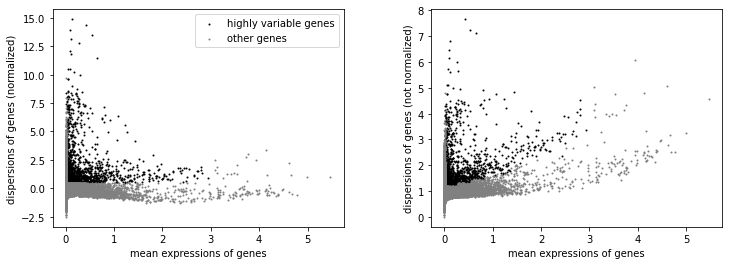

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

**Filter the genes to only those marked as highly-variable**

In [18]:
adata = adata[:, adata.var.highly_variable]

**Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.**

In [19]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical


**Run PCA**

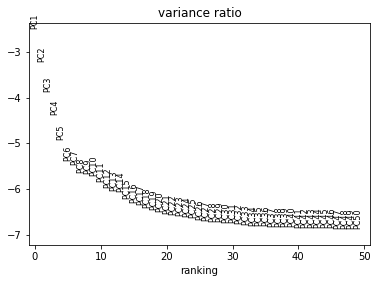

In [20]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

**Computing the neighborhood graph, umap and clusters**

In [21]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# Embedding the neighborhood graph
sc.tl.umap(adata)
# Clustering the neighborhood graph
sc.tl.leiden(adata)

**Visualizing the clusters and whether or not there's a corresponding contig**.

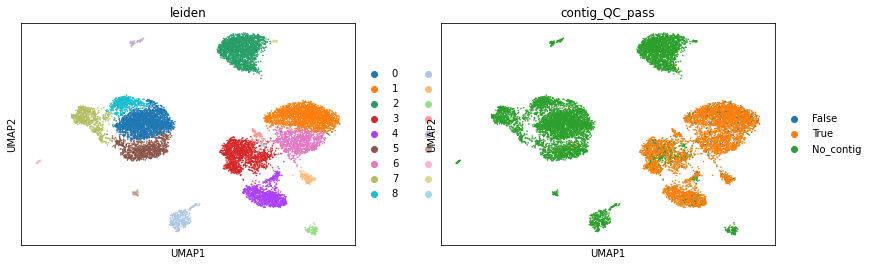

In [22]:
sc.pl.umap(adata, color=['leiden', 'contig_QC_pass'])

**Visualizing some T cell genes.**

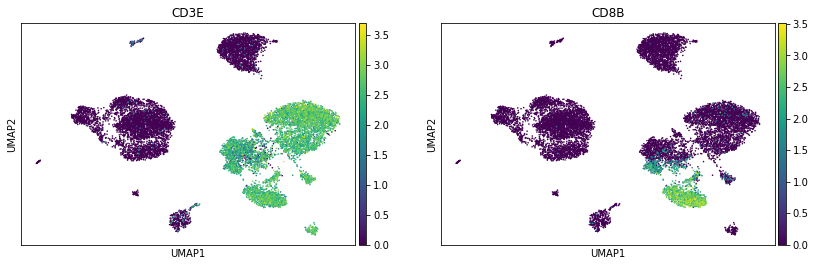

In [23]:
sc.pl.umap(adata, color=['CD3E', 'CD8B'])

**Find clones.**

Here we specify `identity = 1` so only cells with identical CDR3 amino acid sequences are grouped into clones/clonotypes. Also specify `locus = 'tr-ab` so that `dandelion` knows how to initialise the TCR data.

In [24]:
ddl.tl.find_clones(vdj, identity = 1, locus = 'tr-ab')
vdj

Finding clones based on VDJ chains : 100%|██████████| 501/501 [00:00<00:00, 862.48it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 4985/4985 [00:00<00:00, 261292.24it/s]


Dandelion class object with n_obs = 4985 and n_contigs = 9200
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'umi_count'
    metadata: 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'v

**Generate TCR network.**

Specify `key = 'sequence_aa'`. Can also try `junction` or `junction_aa` if just want to visualise the CDR3 linkage.

In [25]:
ddl.tl.generate_network(vdj, key = 'sequence_aa', locus = 'tr-ab')

Linking edges : 100%|██████████| 4945/4945 [00:32<00:00, 154.16it/s]


generating network layout


In [26]:
vdj

Dandelion class object with n_obs = 4985 and n_contigs = 9200
    data: 'cell_id', 'clone_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'duplicate_count', 'is_cell', 'locus', 'sample_id', 'umi_count'
    metadata: 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'v_call_VJ', 'j_call_VDJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'duplicate_count_VDJ_0', 'duplicate_count_VJ_0', 'duplicate_count_VJ_1', 'junction_aa_VDJ', 'junction_aa_VJ', 'status', 'status_summary', 'productive', 'productive_summary', 'isotype', 'isotype_summary', 'v

**Plotting in `scanpy`.**

In [27]:
ddl.tl.transfer(adata, vdj) # this will include singletons. To show only expanded clones, specify expanded_only=True

converting matrices
Updating anndata slots


... storing 'clone_id' as categorical
... storing 'locus_VDJ' as categorical
... storing 'locus_VJ' as categorical
... storing 'productive_VDJ' as categorical
... storing 'productive_VJ' as categorical
... storing 'v_call_VDJ' as categorical
... storing 'v_call_VJ' as categorical
... storing 'j_call_VDJ' as categorical
... storing 'j_call_VJ' as categorical
... storing 'c_call_VDJ' as categorical
... storing 'c_call_VJ' as categorical
... storing 'junction_aa_VDJ' as categorical
... storing 'junction_aa_VJ' as categorical
... storing 'status' as categorical
... storing 'status_summary' as categorical
... storing 'productive' as categorical
... storing 'productive_summary' as categorical
... storing 'isotype' as categorical
... storing 'isotype_summary' as categorical
... storing 'vdj_status' as categorical
... storing 'vdj_status_summary' as categorical
... storing 'VDJ_chain_status_summary' as categorical


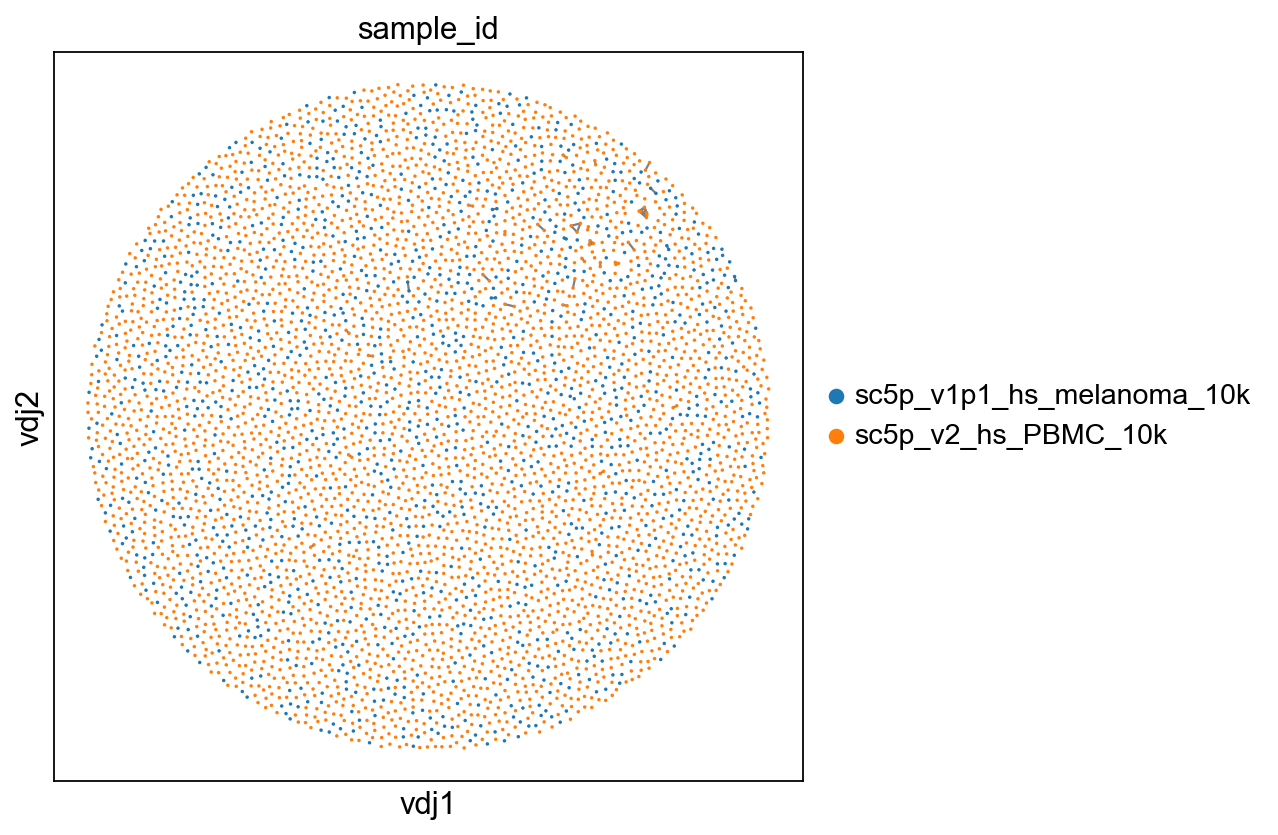

In [28]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, 
                     color = ['sample_id'], 
                     edges_width = 1) 

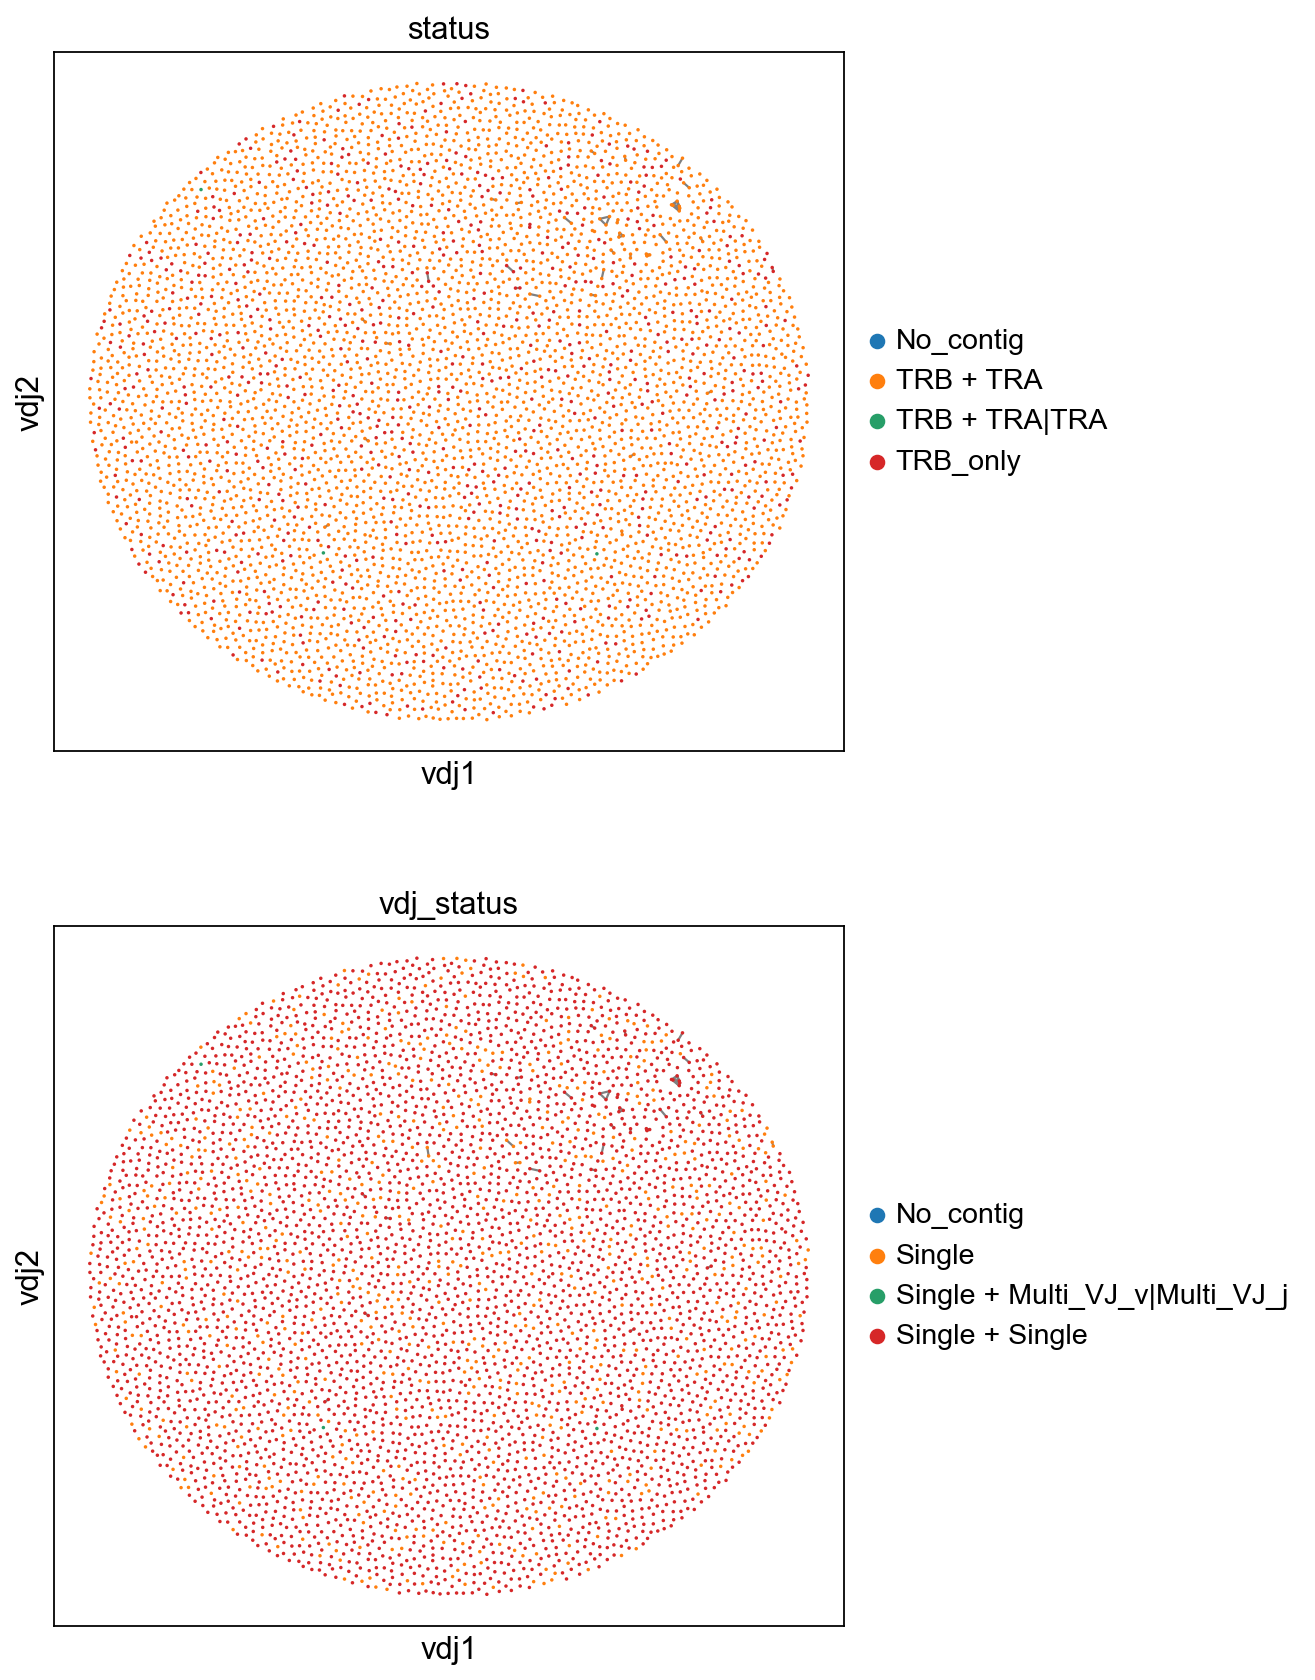

In [29]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, 
                     color = ['status', 'vdj_status'], 
                     ncols = 1, 
                     legend_fontoutline=3, 
                     edges_width = 1)

In [30]:
ddl.tl.transfer(adata, vdj, expanded_only = True)

converting matrices
Updating anndata slots


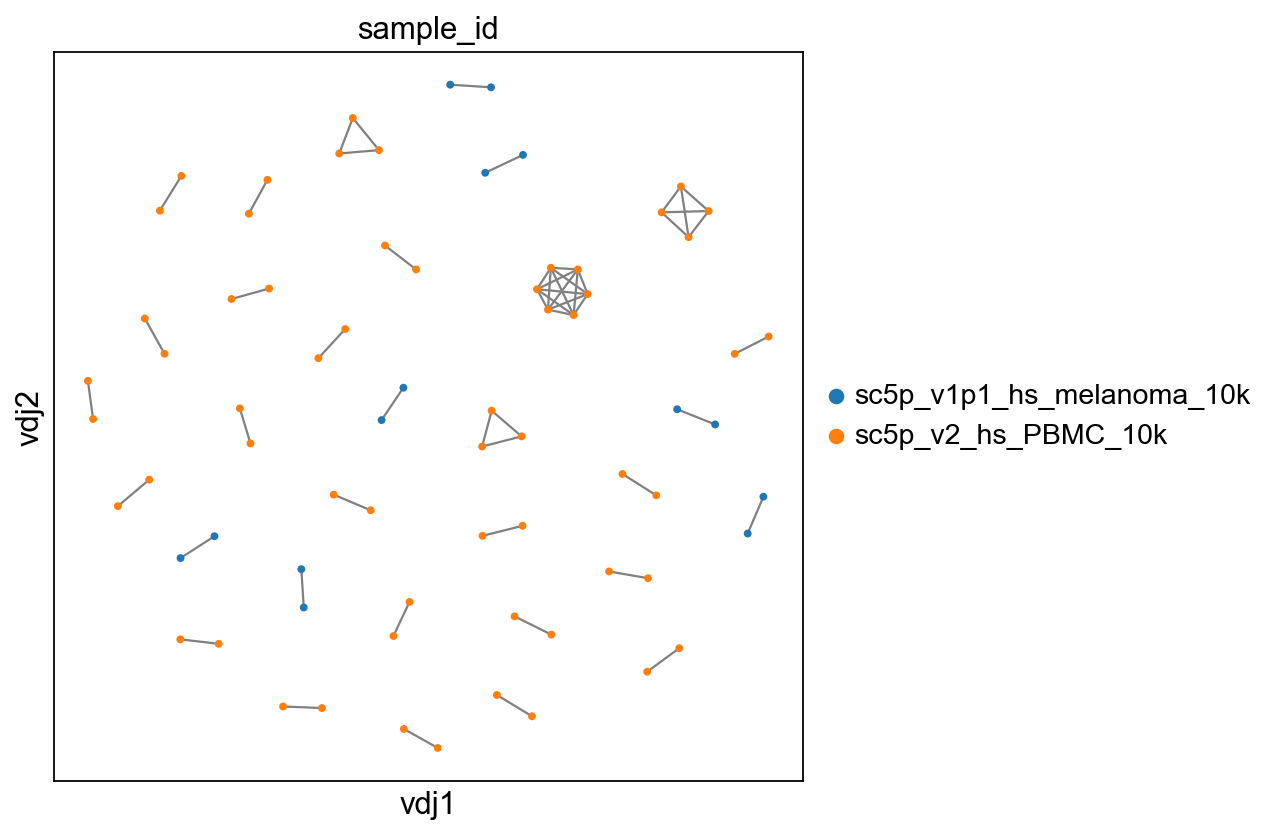

In [35]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, 
                     color = ['sample_id'], 
                     edges_width = 1,
                     size = 50) 

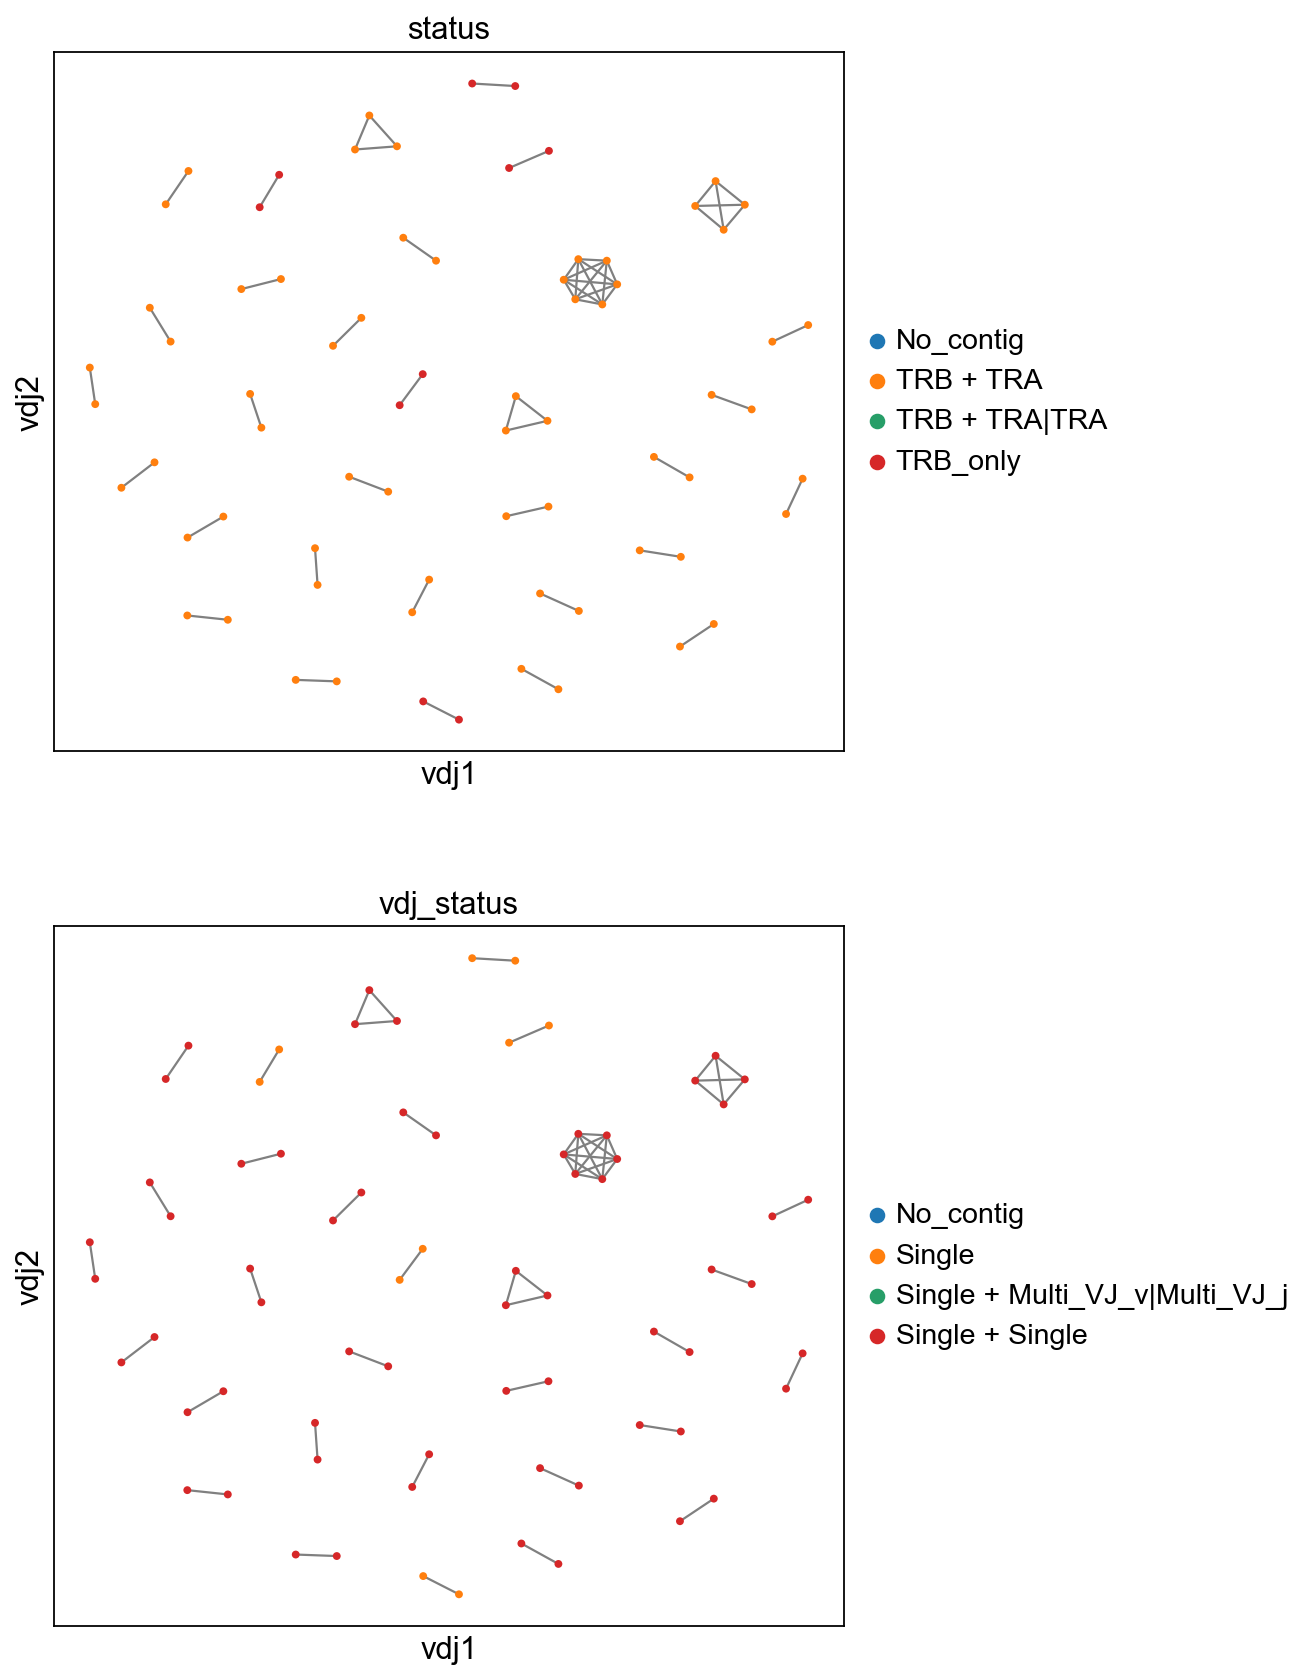

In [36]:
sc.set_figure_params(figsize = [6,6])
ddl.pl.clone_network(adata, 
                     color = ['status', 'vdj_status'], 
                     ncols = 1, 
                     legend_fontoutline=3, 
                     edges_width = 1,
                     size = 50)

**Finish.**

We can save the files.

In [37]:
adata.write('adata_tcr.h5ad', compression = 'gzip')

In [38]:
vdj.write_h5('dandelion_results_tcr.h5', complib = 'blosc:lz4')